Time series
Lab 4: Forecasting with exponential smoothing model
PART 2

Imports

In [1]:
!pip install scikit-learn==1.4.1.post1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [43]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sk
from scipy import stats

Dataset

In [3]:
dataset = pd.read_csv("Retail_sales_of_electricity_United_States_monthly.csv",
                          skiprows=4, sep=',')
dataset.dropna(inplace=True)
pd.set_option('display.max_columns', None)
dataset.head()

,Month,all sectors million kilowatthours,residential million kilowatthours,commercial million kilowatthours,industrial million kilowatthours
1,Oct 2022,292257.74617,103152.07773,106857.96303,81701.39939
4,Sep 2022,297195.94414,99792.19117,111851.35754,85017.01500
5,Aug 2022,340543.84071,129241.31830,124195.27519,86549.52268
6,Jul 2022,389626.28230,160271.46691,135675.95261,93143.14117
9,Jun 2022,389214.17473,164276.57789,133951.71136,90419.84289


Data preprocesing and plotting

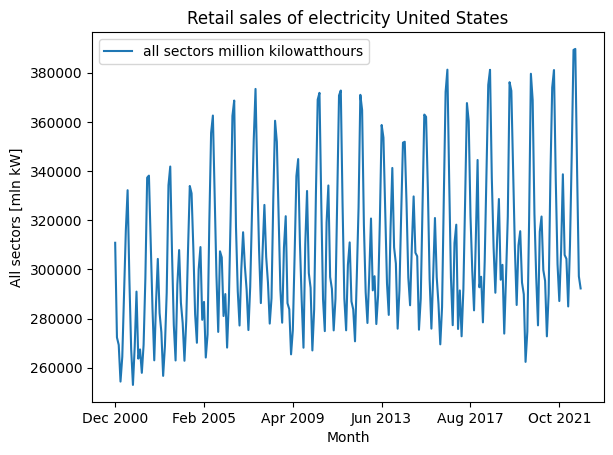

In [4]:
working_dataset = dataset[["Month", "all sectors million kilowatthours"]]
working_dataset = working_dataset.iloc[::-1]
working_dataset.plot(x="Month", y="all sectors million kilowatthours")
plt.ylabel("All sectors [mln kW]")
plt.title("Retail sales of electricity United States")
plt.subplots_adjust(left=0.15, right=0.95)
plt.show()

Splitting data to train and test data subsets

In [5]:
working_dataset.reset_index(inplace=True)
working_dataset = working_dataset[["Month", "all sectors million kilowatthours"]]
[index] = working_dataset.loc[working_dataset["Month"] == "Oct 2021"].index
train_set = working_dataset.iloc[:index+1]
test_set = working_dataset.iloc[index+1:]



---


Making a decomposition of a time series
Additive decomposition:

Additive decomposition can be present as a sum of 3 values:

yₜ = Sₜ + Tₜ + Rₜ,

where:

Sₜ - seasonal component

Tₜ - trend-cycle component

Rₜ - residual(reminder) component

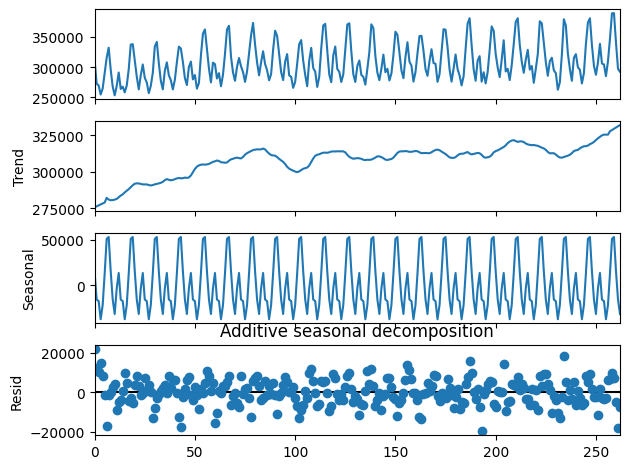

In [6]:
add_decomposition = seasonal_decompose(working_dataset[["all sectors million kilowatthours"]], model='additive', period=12, extrapolate_trend='freq')
add_decomposition.plot()
plt.title("Additive seasonal decomposition")
plt.show()

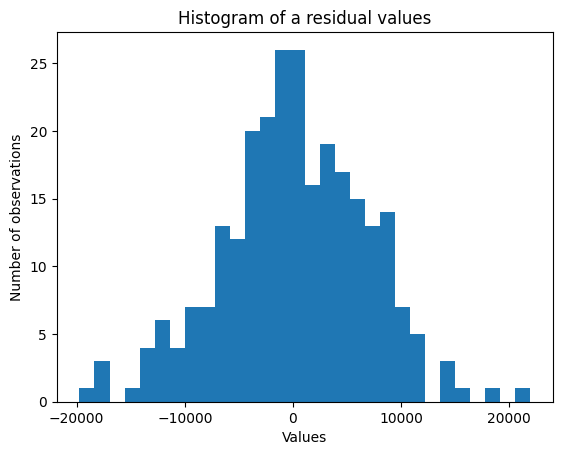

In [7]:
plt.hist(add_decomposition.resid, bins=30)
plt.ylabel("Number of observations")
plt.xlabel("Values")
plt.title("Histogram of a residual values")
plt.show()

On the histogram one can see that mean value could be around 0 which would be a great value.

Calculating mean value:

In [8]:
print("Additive decomposition mean value of residuals: ",np.mean(add_decomposition.resid))

Additive decomposition mean value of residuals:  127.42166392679593


As can be seen mean value isn't close to 0 but looking on the all values one can accept mean value of 127.

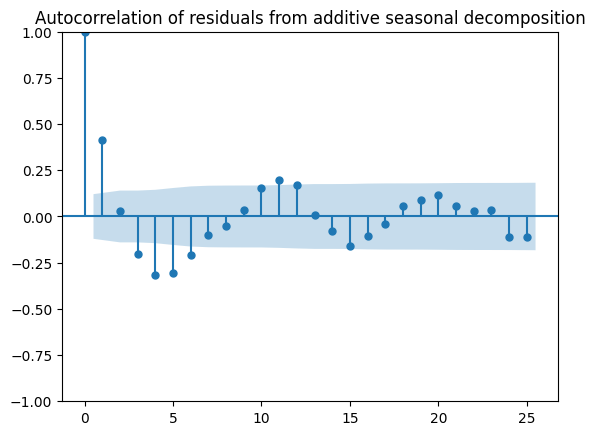

In [9]:
sm.graphics.tsa.plot_acf(add_decomposition.resid, title="Autocorrelation of residuals from additive seasonal decomposition")
plt.show()

On figure above is presented autocorrelation on which one can see how correlated data is – in this case there is medium correlation between original data and moved by 1.

All of this can suggest that forecasting using additive might be good.



---

Plots and autocorrelation for multiplicative decomposition:

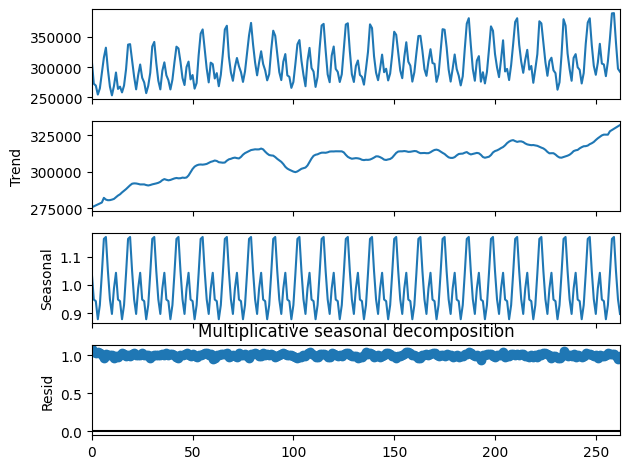

In [10]:
mul_decomposition = seasonal_decompose(working_dataset[["all sectors million kilowatthours"]], model='multiplicative', period=12, extrapolate_trend='freq')
mul_decomposition.plot()
plt.title("Multiplicative seasonal decomposition")
plt.show()

Compering residual graph from additive and multiplicative decomposition one can see that residual values from multiplicative decomp have very small variance where additive decomposition have bigger variance

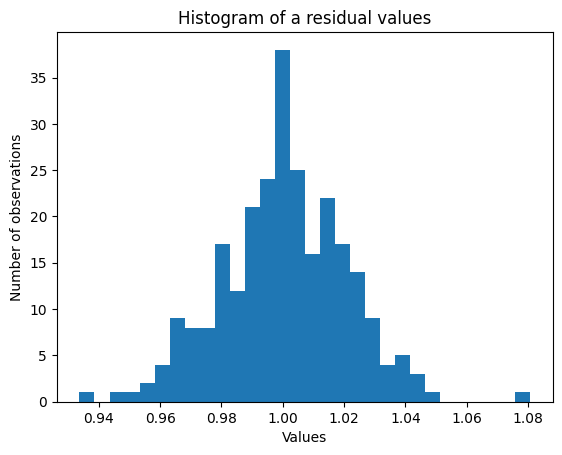

In [11]:
plt.hist(mul_decomposition.resid, bins=30)
plt.ylabel("Number of observations")
plt.xlabel("Values")
plt.title("Histogram of a residual values")
plt.show()

Here one can see that there is no way to get mean value of residual equal 0.

Calculating mean value:

In [12]:
print("Multiplicative decomposition resid values: ",np.mean(mul_decomposition.resid))

Multiplicative decomposition resid values:  1.0004460236872768


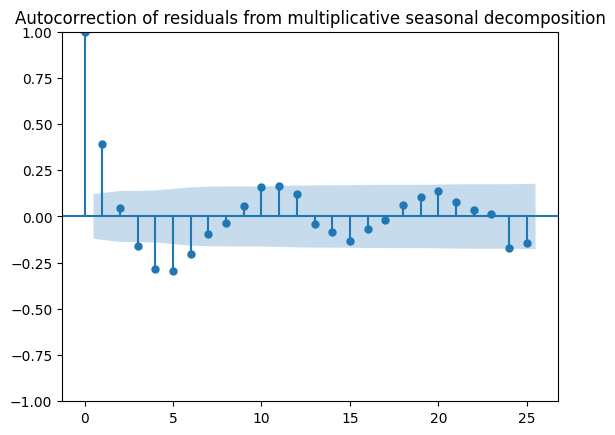

In [13]:
sm.graphics.tsa.plot_acf(mul_decomposition.resid,
                             title="Autocorrection of residuals from multiplicative seasonal decomposition")
plt.show()

Autocorrelation of residuals from multiplicative decomposition looks almost the same as autocorrelation of resid from additive decomposition.

Using [this](https://otexts.com/fpp3/diagnostics.html) I can say that forecasting method can be improved because residuals don't have mean value equal to 0 and there is medium correlation between residuals (Correlation between 0 and 1 is around 0.4).

Looking on those result i belive that using trend and/or seasonal as 'add' should give the best results.

Data set was split into two subsets.

Train set had 250 points and test set had 12 points.
Firstly Holt-Winter model was train on train set with proper parameters:
-	Trend: add, seasonal: add
-	Trend: add, seasonal: mul
-	Trend: mul, seasonal: add
-	Trend: mul, seasonal: mul




---

Trend: **add**

Seasonal: **add**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


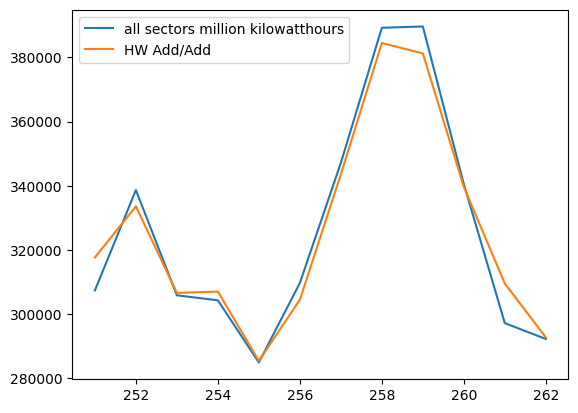

Forecast Holt-Winter Trend=add and Seasonal=add MAPE:  0.014013606297676702
Forecast Holt-Winter Trend=add and Seasonal=add MAE:  4151.8700176551065
Forecast Holt-Winter Trend=add and Seasonal=add RMSE:  5953.590673333809


In [14]:
fitHoltWinterTaddSadd = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='add',seasonal_periods=12).fit()
fcastHoltWinterTaddSadd = fitHoltWinterTaddSadd.forecast(len(test_set)).rename('HS Trend=add seasonal=add')
test_set.plot(legend=True, label="Test")
fcastHoltWinterTaddSadd.plot(legend=True, label="HW Add/Add")
plt.show()
print("Forecast Holt-Winter Trend=add and Seasonal=add MAPE: ", sk.mean_absolute_percentage_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd))
print("Forecast Holt-Winter Trend=add and Seasonal=add MAE: ", sk.median_absolute_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd))
print("Forecast Holt-Winter Trend=add and Seasonal=add RMSE: ", sk.root_mean_squared_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd))



---


Trend: **add**

Seasonal: **mul**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


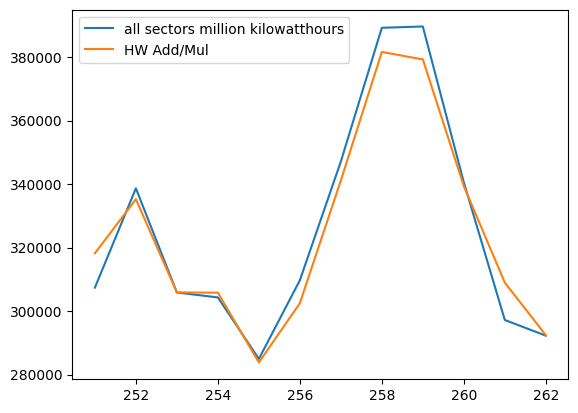

Forecast Holt-Winter Trend=add and Seasonal=mul MAPE:  0.015381595602294707
Forecast Holt-Winter Trend=add and Seasonal=mul MAE:  4695.533401259279
Forecast Holt-Winter Trend=add and Seasonal=mul RMSE:  6617.067245934402


In [15]:
fitHoltWinterTaddSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='mul',seasonal_periods=12).fit()
fcastHoltWinterTaddSmul = fitHoltWinterTaddSmul.forecast(len(test_set)).rename('HS Trend=add seasonal=mul')
test_set.plot(legend=True, label="Test")
fcastHoltWinterTaddSmul.plot(legend=True, label="HW Add/Mul")
plt.show()
print("Forecast Holt-Winter Trend=add and Seasonal=mul MAPE: ", sk.mean_absolute_percentage_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul))
print("Forecast Holt-Winter Trend=add and Seasonal=mul MAE: ", sk.median_absolute_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul))
print("Forecast Holt-Winter Trend=add and Seasonal=mul RMSE: ", sk.root_mean_squared_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul))



---


Trend: **add**

Seasonal: **mul**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


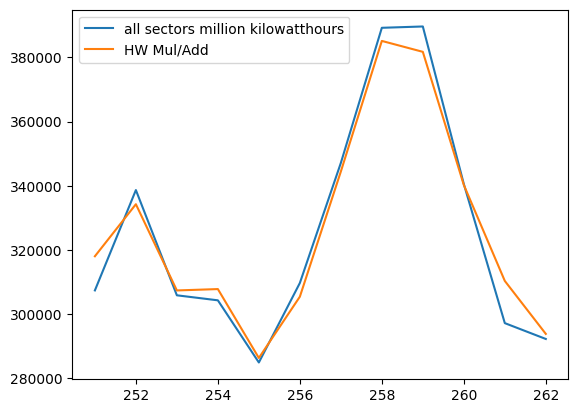

Forecast Holt-Winter Trend=mul and Seasonal=add MAPE:  0.014324829142319225
Forecast Holt-Winter Trend=mul and Seasonal=add MAE:  3796.879159480246
Forecast Holt-Winter Trend=mul and Seasonal=add RMSE:  5981.017272216559


In [16]:
fitHoltWinterTmulSadd = HWES(train_set[["all sectors million kilowatthours"]], trend='mul', seasonal='add',seasonal_periods=12).fit()
fcastHoltWinterTmulSadd = fitHoltWinterTmulSadd.forecast(len(test_set)).rename('HS Trend=mul seasonal=add')
test_set.plot(legend=True, label="Test")
fcastHoltWinterTmulSadd.plot(legend=True, label="HW Mul/Add")
plt.show()
print("Forecast Holt-Winter Trend=mul and Seasonal=add MAPE: ", sk.mean_absolute_percentage_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd))
print("Forecast Holt-Winter Trend=mul and Seasonal=add MAE: ", sk.median_absolute_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd))
print("Forecast Holt-Winter Trend=mul and Seasonal=add RMSE: ", sk.root_mean_squared_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd))



---


Trend: **add**

Seasonal: **mul**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


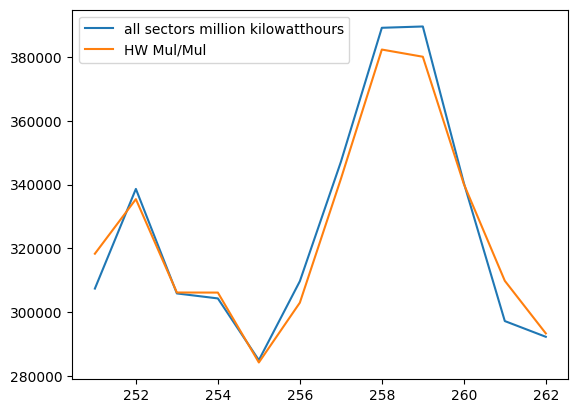

Forecast Holt-Winter Trend=mul and Seasonal=mul MAPE:  0.015066685749926348
Forecast Holt-Winter Trend=mul and Seasonal=mul MAE:  4276.958916205069
Forecast Holt-Winter Trend=mul and Seasonal=mul RMSE:  6489.41957325737


In [17]:
fitHoltWinterTmulSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='mul', seasonal='mul',seasonal_periods=12).fit()
fcastHoltWinterTmulSmul = fitHoltWinterTmulSmul.forecast(len(test_set)).rename('HS Trend=mul seasonal=mul')
test_set.plot(legend=True, label="Test")
fcastHoltWinterTmulSmul.plot(legend=True, label="HW Mul/Mul")
plt.show()
print("Forecast Holt-Winter Trend=mul and Seasonal=mul MAPE: ", sk.mean_absolute_percentage_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul))
print("Forecast Holt-Winter Trend=mul and Seasonal=mul MAE: ", sk.median_absolute_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul))
print("Forecast Holt-Winter Trend=mul and Seasonal=mul RMSE: ", sk.root_mean_squared_error(test_set[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul))


  \begin{array}{|c|c|c|c|c|}\hline
  \mathcal{} & {Trend = Add \\ Seasonal = Add} & {Trend = Add \\ Seasonal = mul} & {Trend = mul \\ Seasonal = Add} & {Trend = mul \\ Seasonal = mul} \\ \hline
  MAPE & 0.014 & 0.015 & 0.014 & 0.015 \\ \hline
  MAE & 4151.870 & 4695.533 & 3796.879 & 4276.958  \\ \hline
  RMSE & 5953.590 & 6617.067 & 5981.017 & 6489.419   \\ \hline
  \end{array}



Looking on those result one can say that the best results can be achieved by using additive trend and seasonal or second option multiplicative trend and additive seasonal.

One can say that because for MAPE, MAE and RMSE the lower number is `better. I have choose 3 different metrics because I was curious how those metrics behave.

MAPE (Mean Absolute Percentage Error) is a common regression machine learning metric, where in sklearn library return value isn't a procentage.
MAPE for time series forecasting can be interpreted as the average percentage error over all time periods in the dataset, specifically the average percentage difference between forecasts and their intended targets. [Source](https://stephenallwright.com/interpret-mape/)

MAE (Mean Absolute Error) is the average absolute error between actual and predicted values. MAE can be interpreted as the average error that the model’s predictions have in comparison with their corresponding actual targets [Source](https://stephenallwright.com/interpret-mae/)

RMSE (Root Mean Squared Error) is the square root of the mean squared error between the predicted and actual values. RMSE can be interpreted as the average error that the model’s predictions have in comparison with the actual, with extra weight added to larger prediction errors. [Source](https://stephenallwright.com/interpret-rmse/)



---

# HOLDOUT

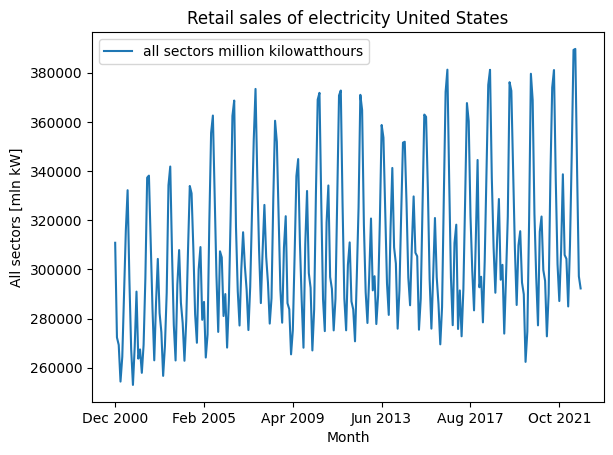

In [51]:
working_dataset = dataset[["Month", "all sectors million kilowatthours"]]
working_dataset = working_dataset.iloc[::-1]
working_dataset.plot(x="Month", y="all sectors million kilowatthours")
plt.ylabel("All sectors [mln kW]")
plt.title("Retail sales of electricity United States")
plt.subplots_adjust(left=0.15, right=0.95)
plt.show()

In [52]:
working_dataset.reset_index(inplace=True)
working_dataset = working_dataset[["Month", "all sectors million kilowatthours"]]
working_dataset

,Month,all sectors million kilowatthours
0,Dec 2000,310816.06880
1,Jan 2001,272334.73804
2,Feb 2001,269298.40142
3,Mar 2001,254390.93545
4,Apr 2001,264490.49166
...,...,...
258,Jun 2022,389214.17473
259,Jul 2022,389626.28230
260,Aug 2022,340543.84071
261,Sep 2022,297195.94414


In [53]:
train_length = 120
test_length = 12
slide_step = 3
start = 0
forecast_errors = dict()

In [54]:
while (train_length + test_length + slide_step + start) < len(working_dataset):
  train_data = working_dataset[start:start+train_length]
  test_data = working_dataset[start+train_length:start+train_length+test_length]

  fitHoltWinterTaddSadd = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTaddSadd = fitHoltWinterTaddSadd.forecast(len(test_set)).rename('HS Trend=add seasonal=add')

  fitHoltWinterTaddSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTaddSmul = fitHoltWinterTaddSmul.forecast(len(test_set)).rename('HS Trend=add seasonal=mul')

  fitHoltWinterTmulSadd = HWES(train_data[["all sectors million kilowatthours"]], trend='mul', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTmulSadd = fitHoltWinterTmulSadd.forecast(len(test_set)).rename('HS Trend=mul seasonal=add')

  fitHoltWinterTmulSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='mul', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTmulSmul = fitHoltWinterTmulSmul.forecast(len(test_set)).rename('HS Trend=mul seasonal=mul')

  forecast_errors[start] = [
                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul)
                            ]

  start += slide_step

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

<Axes: >

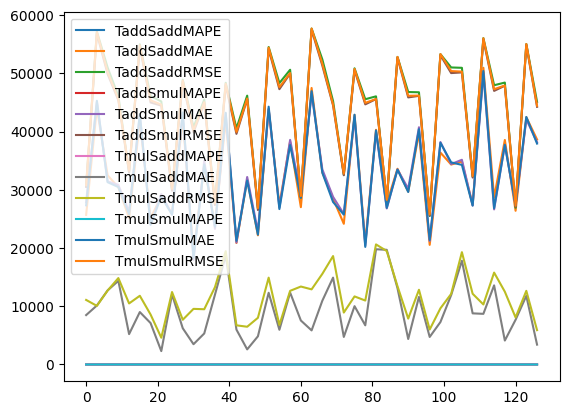

In [55]:
forecast_errors_pd = pd.DataFrame.from_dict(forecast_errors,orient='index',
                       columns=['TaddSaddMAPE', 'TaddSaddMAE', 'TaddSaddRMSE', 'TaddSmulMAPE', 'TaddSmulMAE', 'TaddSmulRMSE', 'TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE', 'TmulSmulMAPE', 'TmulSmulMAE', 'TmulSmulRMSE'])
forecast_errors_pd.plot()

In [56]:
forecast_errors_pd.describe()

,TaddSaddMAPE,TaddSaddMAE,TaddSaddRMSE,TaddSmulMAPE,TaddSmulMAE,TaddSmulRMSE,TmulSaddMAPE,TmulSaddMAE,TmulSaddRMSE,TmulSmulMAPE,TmulSmulMAE,TmulSmulRMSE
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,0.116854,32536.741477,44156.769686,0.115923,32737.057514,43663.105394,0.031968,9308.492012,11683.179936,0.116433,32626.639131,43884.762351
std,0.024678,8152.516141,9680.051351,0.024481,8162.674789,9527.673659,0.012725,4655.652439,3968.449426,0.024553,8261.007730,9510.135911
min,0.071984,19047.783414,25499.775278,0.071932,17964.723721,25583.141009,0.011888,2296.941357,4594.609378,0.072404,18265.365277,25769.178884
25%,0.097489,26143.848575,36815.155716,0.096255,26718.608273,36282.071374,0.021361,5590.193245,8753.527380,0.096919,26770.541342,36610.614169
50%,0.122498,31758.521091,46174.765802,0.121647,31444.426304,45588.214669,0.031461,8697.397907,11799.302528,0.121773,31308.473350,45679.365025
75%,0.133964,39204.177786,50982.319768,0.132898,39254.785056,50107.170443,0.038532,12172.326308,13331.921807,0.133330,39135.254464,50348.292485
max,0.159037,50959.926028,57700.735737,0.158585,50029.589310,57487.790806,0.058926,19791.890462,20621.432399,0.159728,50404.630121,57710.344305


Different slide step

In [57]:
train_length = 120
test_length = 12
slide_step = 12
start = 0
forecast_errors_12_step = dict()

In [58]:
while (train_length + test_length + slide_step + start) < len(working_dataset):
  train_data = working_dataset[start:start+train_length]
  test_data = working_dataset[start+train_length:start+train_length+test_length]

  fitHoltWinterTaddSadd = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTaddSadd = fitHoltWinterTaddSadd.forecast(len(test_set)).rename('HS Trend=add seasonal=add')

  fitHoltWinterTaddSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTaddSmul = fitHoltWinterTaddSmul.forecast(len(test_set)).rename('HS Trend=add seasonal=mul')

  fitHoltWinterTmulSadd = HWES(train_data[["all sectors million kilowatthours"]], trend='mul', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTmulSadd = fitHoltWinterTmulSadd.forecast(len(test_set)).rename('HS Trend=mul seasonal=add')

  fitHoltWinterTmulSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='mul', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTmulSmul = fitHoltWinterTmulSmul.forecast(len(test_set)).rename('HS Trend=mul seasonal=mul')

  forecast_errors_12_step[start] = [
                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul)
                            ]

  start += slide_step

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

<Axes: >

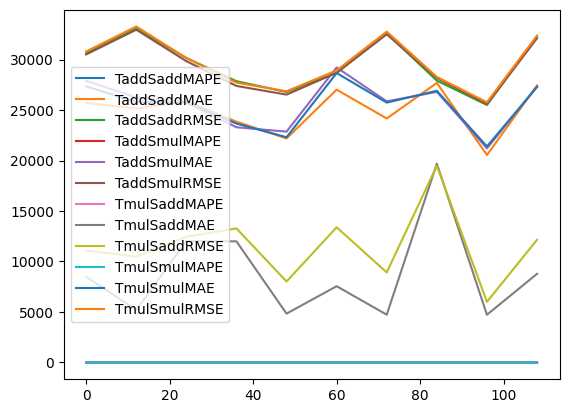

In [59]:
forecast_errors_12_pd = pd.DataFrame.from_dict(forecast_errors_12_step,orient='index',
                       columns=['TaddSaddMAPE', 'TaddSaddMAE', 'TaddSaddRMSE', 'TaddSmulMAPE', 'TaddSmulMAE', 'TaddSmulRMSE', 'TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE', 'TmulSmulMAPE', 'TmulSmulMAE', 'TmulSmulRMSE'])
forecast_errors_12_pd.plot()

In [60]:
forecast_errors_12_pd.describe()

,TaddSaddMAPE,TaddSaddMAE,TaddSaddRMSE,TaddSmulMAPE,TaddSmulMAE,TaddSmulRMSE,TmulSaddMAPE,TmulSaddMAE,TmulSaddRMSE,TmulSmulMAPE,TmulSmulMAE,TmulSmulRMSE
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.082578,24961.590035,29545.286139,0.082441,25644.943913,29427.066154,0.031101,8804.665504,11524.465550,0.082968,25484.327626,29690.516927
std,0.007867,2317.274977,2605.917280,0.007828,2479.858442,2579.551847,0.011615,4745.439756,3680.880982,0.007896,2338.658917,2599.826516
min,0.071984,20543.440860,25499.775278,0.071932,21205.636464,25583.141009,0.015653,4726.152898,6003.568454,0.072404,21393.381342,25769.178884
25%,0.077391,23928.427338,27870.317312,0.077270,23908.887428,27582.705769,0.021566,4932.782921,9309.368878,0.077750,24178.954895,27852.152768
50%,0.081337,25420.698998,29409.513726,0.081206,26056.634188,29267.717559,0.032155,8018.297342,11617.102303,0.081687,25775.804492,29539.145330
75%,0.089565,26736.525225,31870.700414,0.089520,27181.485463,31705.543941,0.037220,11191.439701,13068.258677,0.090064,27193.167927,31979.573427
max,0.093612,27686.763535,33085.509930,0.093814,29218.408213,32954.986531,0.054966,19693.703810,19481.732504,0.094379,28663.452911,33274.202020


Different train test size

In [61]:
train_length = 60
test_length = 12
slide_step = 3
start = 0
forecast_errors_60_length = dict()

In [ ]:
while (train_length + test_length + slide_step + start) < len(working_dataset):
  train_data = working_dataset[start:start+train_length]
  test_data = working_dataset[start+train_length:start+train_length+test_length]

  fitHoltWinterTaddSadd = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTaddSadd = fitHoltWinterTaddSadd.forecast(len(test_set)).rename('HS Trend=add seasonal=add')

  fitHoltWinterTaddSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='add', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTaddSmul = fitHoltWinterTaddSmul.forecast(len(test_set)).rename('HS Trend=add seasonal=mul')

  fitHoltWinterTmulSadd = HWES(train_data[["all sectors million kilowatthours"]], trend='mul', seasonal='add',seasonal_periods=12).fit()
  fcastHoltWinterTmulSadd = fitHoltWinterTmulSadd.forecast(len(test_set)).rename('HS Trend=mul seasonal=add')

  fitHoltWinterTmulSmul = HWES(train_set[["all sectors million kilowatthours"]], trend='mul', seasonal='mul',seasonal_periods=12).fit()
  fcastHoltWinterTmulSmul = fitHoltWinterTmulSmul.forecast(len(test_set)).rename('HS Trend=mul seasonal=mul')

  forecast_errors_60_length[start] = [
                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTaddSmul),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSadd),

                            sk.mean_absolute_percentage_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.median_absolute_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul),
                            sk.root_mean_squared_error(test_data[["all sectors million kilowatthours"]], fcastHoltWinterTmulSmul)
                            ]

  start += slide_step

<Axes: >

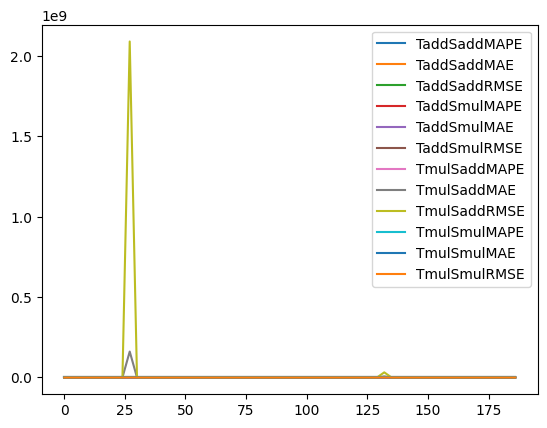

In [63]:
forecast_errors_60_length = pd.DataFrame.from_dict(forecast_errors_60_length,orient='index',
                       columns=['TaddSaddMAPE', 'TaddSaddMAE', 'TaddSaddRMSE', 'TaddSmulMAPE', 'TaddSmulMAE', 'TaddSmulRMSE', 'TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE', 'TmulSmulMAPE', 'TmulSmulMAE', 'TmulSmulRMSE'])
forecast_errors_60_length.plot()

Compering the best combination Trend/Sesonal for different holdout parameters

In [64]:
forecast_errors_60_length_desc = forecast_errors_60_length[['TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE']].describe()
forecast_errors_60_length_desc.rename(columns = {'TmulSaddMAPE':'MAPE for 5 years', 'TmulSaddMAE':'MAE for 5 years', 'TmulSaddRMSE':'RMSE for 5 years'}, inplace = True)

forecast_errors_12_pd_desc = forecast_errors_12_pd[['TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE']].describe()
forecast_errors_12_pd_desc.rename(columns = {'TmulSaddMAPE':'MAPE for 1 year step', 'TmulSaddMAE':'MAE for 1 year step', 'TmulSaddRMSE':'RMSE for 1 year step'}, inplace = True)

forecast_errors_desc = forecast_errors_pd[['TmulSaddMAPE', 'TmulSaddMAE', 'TmulSaddRMSE']].describe()
forecast_errors_desc.rename(columns = {'TmulSaddMAPE':'Normal MAPE', 'TmulSaddMAE':'Normal MAE', 'TmulSaddRMSE':'Normal RMSE'}, inplace = True)


forecastsForTmulSadd = pd.concat([forecast_errors_desc, forecast_errors_12_pd_desc, forecast_errors_60_length_desc], axis=1)

In [65]:
forecastsForTmulSadd

,Normal MAPE,Normal MAE,Normal RMSE,MAPE for 1 year step,MAE for 1 year step,RMSE for 1 year step,MAPE for 5 years,MAE for 5 years,RMSE for 5 years
count,43.000000,43.000000,43.000000,10.000000,10.000000,10.000000,63.000000,6.300000e+01,6.300000e+01
mean,0.031968,9308.492012,11683.179936,0.031101,8804.665504,11524.465550,58.707146,2.670304e+06,3.368591e+07
std,0.012725,4655.652439,3968.449426,0.011615,4745.439756,3680.880982,457.903591,2.030996e+07,2.632353e+08
min,0.011888,2296.941357,4594.609378,0.015653,4726.152898,6003.568454,0.013227,3.294483e+03,5.296307e+03
25%,0.021361,5590.193245,8753.527380,0.021566,4932.782921,9309.368878,0.022499,6.323661e+03,8.584045e+03
50%,0.031461,8697.397907,11799.302528,0.032155,8018.297342,11617.102303,0.029312,8.324638e+03,1.084503e+04
75%,0.038532,12172.326308,13331.921807,0.037220,11191.439701,13068.258677,0.037198,1.180336e+04,1.311134e+04
max,0.058926,19791.890462,20621.432399,0.054966,19693.703810,19481.732504,3634.999758,1.611886e+08,2.089648e+09


In [66]:
mapeOfForecasts = forecastsForTmulSadd[['Normal MAPE', 'MAPE for 1 year step', 'MAPE for 5 years']]
mapeOfForecasts

,Normal MAPE,MAPE for 1 year step,MAPE for 5 years
count,43.000000,10.000000,63.000000
mean,0.031968,0.031101,58.707146
std,0.012725,0.011615,457.903591
min,0.011888,0.015653,0.013227
25%,0.021361,0.021566,0.022499
50%,0.031461,0.032155,0.029312
75%,0.038532,0.037220,0.037198
max,0.058926,0.054966,3634.999758


Searching for the data to plot

In [83]:
maeOfForecasts = forecastsForTmulSadd[['Normal MAE', 'MAE for 1 year step', 'MAE for 5 years']]
maeOfForecasts

,Normal MAE,MAE for 1 year step,MAE for 5 years
count,43.000000,10.000000,6.300000e+01
mean,9308.492012,8804.665504,2.670304e+06
std,4655.652439,4745.439756,2.030996e+07
min,2296.941357,4726.152898,3.294483e+03
25%,5590.193245,4932.782921,6.323661e+03
50%,8697.397907,8018.297342,8.324638e+03
75%,12172.326308,11191.439701,1.180336e+04
max,19791.890462,19693.703810,1.611886e+08


In [84]:
rmseOfForecasts = forecastsForTmulSadd[['Normal RMSE', 'RMSE for 1 year step', 'RMSE for 5 years']]
rmseOfForecasts

,Normal RMSE,RMSE for 1 year step,RMSE for 5 years
count,43.000000,10.000000,6.300000e+01
mean,11683.179936,11524.465550,3.368591e+07
std,3968.449426,3680.880982,2.632353e+08
min,4594.609378,6003.568454,5.296307e+03
25%,8753.527380,9309.368878,8.584045e+03
50%,11799.302528,11617.102303,1.084503e+04
75%,13331.921807,13068.258677,1.311134e+04
max,20621.432399,19481.732504,2.089648e+09
